# Inventory Monitoring at Distribution Centers 



## Overview

The goal of this project is to build a pipeline to process real-world, user-supplied images. 
Particularly, this project classifies a bin image by the number of objects present using 
Convolutional Neural Network (CNN). Given an inventory bin image, the algorithm will identify an 
estimate of the count of objects in the image through classification based on the Amazon Bin Image datasets the model is trained on.

• Inventory monitoring enables the maximum amount of profit from the least amount of investment in inventory without affecting customer satisfaction. Done right, it can help avoid problems, such as out-of-stock (stockout) events.



In [78]:

import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
import json


In [6]:
!pip install torch

In [7]:
!pip install torchvision

In [5]:
import boto3
import torch
import sagemaker
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation


The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 1/2299 [00:00<06:38,  5.76it/s]

 98%|█████████▊| 2250/2299 [04:37<00:09,  5.33it/s]

In [20]:
import sagemaker

# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()

# Retrieve the sagemaker S3 bucket, region and role
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-754226678211
AWS Region: us-east-1


Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20220124T164987 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


RoleArn: arn:aws:iam::754226678211:role/service-role/AmazonSageMaker-ExecutionRole-20220124T164987


## Dataset


### Overview of Dataset and Inputs used

• Data can be downloaded from Amazon Open Data website https://registry.opendata.aws/amazon-bin-imagery/
• Data is captured by Amazon in their Fulfilment centre and has around 50000 images
• License
Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States (CC BY-NC-SA 3.0 US) https://creativecommons.org/licenses/by-nc-sa/3.0/us/
• Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers.
Inputs
There are two set of inputs for the model training
1. Images for the model, which is available in the source as JPEG file
Example
https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg
2. JSON format with meta data for the image
Example https://aft-vbi-pds.s3.amazonaws.com/metadata/523.json.

From the JSON file, we can filter the target label which the quantity of the objects in the image

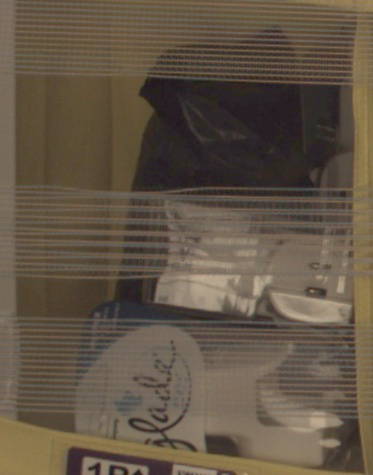

In [14]:
import requests
from PIL import Image
import io

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/1005.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [15]:

os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-studio-5cmd003gb8u/capstone-project/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-studio-5cmd003gb8u/capstone-project/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-studio-5cmd003gb8u/capstone-project/output/'

In [17]:
%%capture
!aws s3 cp train_data s3://sagemaker-studio-5cmd003gb8u/capstone-project/ --recursive

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [26]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values




hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([10,15, 25 , 30 ])
}



In [22]:
role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20211102T122677 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


In [24]:


estimator = PyTorch(
    entry_point="tuner.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

In [27]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [20]:
tuner.fit({"training": "s3://udacitycapstone9/"})


In [29]:


tuner.describe()



{'HyperParameterTuningJobName': 'pytorch-training-211214-1932',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:701620947472:hyper-parameter-tuning-job/pytorch-training-211214-1932',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 2,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"']},
    {'Name': 'epochs', 'Values': ['"10"', '"15"', '"25"', '"30"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_na

In [30]:


tuner.describe().keys()



dict_keys(['HyperParameterTuningJobName', 'HyperParameterTuningJobArn', 'HyperParameterTuningJobConfig', 'TrainingJobDefinition', 'HyperParameterTuningJobStatus', 'CreationTime', 'HyperParameterTuningEndTime', 'LastModifiedTime', 'TrainingJobStatusCounters', 'ObjectiveStatusCounters', 'BestTrainingJob', 'ResponseMetadata'])

In [21]:
lengths

[5221, 2611, 2609]

In [31]:


tuner.describe()['HyperParameterTuningJobName']



'pytorch-training-211214-1932'

In [32]:


from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)



,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""","""25""",0.067109,pytorch-training-211214-1932-001-39a1db98,Completed,50.0,2021-12-14 19:35:36+00:00,2021-12-14 19:57:56+00:00,1340.0
0,"""128""","""15""",0.017455,pytorch-training-211214-1932-002-3f0e8060,Completed,49.0,2021-12-14 19:35:19+00:00,2021-12-14 19:56:24+00:00,1265.0


In [7]:
TrainingJobName= 'pytorch-training-211214-1932-002-3f0e8060'

In [8]:
estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)


2021-12-14 19:56:24 Starting - Preparing the instances for training
2021-12-14 19:56:24 Downloading - Downloading input data
2021-12-14 19:56:24 Training - Training image download completed. Training in progress.
2021-12-14 19:56:24 Uploading - Uploading generated training model
2021-12-14 19:56:24 Completed - Training job completed


In [9]:
best_estimator=estimator

In [29]:
estimator.hyperparameters()

{'batch_size': '128',
 'learning_rate': '"\\"0.017454935661745122\\""',
 'epochs': '15',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-18-39-925/source/sourcedir.tar.gz"',
 'sagemaker_program': '"train.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"Training-job-2021-12-15-15-18-39-925"',
 'sagemaker_region': '"us-east-1"'}

In [30]:
hyperparameters = {"batch_size": int(estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": 0.01745493566174512, \
                   "epochs" : 15
                                  }
hyperparameters

{'batch_size': 128, 'learning_rate': 0.01745493566174512, 'epochs': 15}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [31]:


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1",
    }
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

In [42]:

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    # hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
    collection_configs=collection_config_list
)

In [43]:


estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Training-job',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)



In [44]:
estimator.fit({"training": "s3://udacitycapstone9/"}, wait=True)

2021-12-15 15:55:12 Starting - Starting the training job...
2021-12-15 15:55:20 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-15 15:56:28 Starting - Preparing the instances for training.........
2021-12-15 15:58:09 Downloading - Downloading input data............
2021-12-15 16:00:13 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-15 16:00:15,191 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-15 16:00:15,194 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-12-15 16:00:15,205 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-15 16:00:18,222 sa

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [45]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2021-12-15 16:22:11.617 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/debug-output
[2021-12-15 16:22:11.956 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 4377 more expected)', IncompleteRead(0 bytes read, 4377 more expected)) while reading s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/debug-output/index/000000000/000000000070_worker_0.json . Will retry now
[2021-12-15 16:22:14.122 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-15 16:22:15.144 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 'layer3.5.relu_input_0',
 'layer3

In [46]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

25

In [47]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
vals_eval

[array(1.4227208, dtype=float32),
 array(1.560559, dtype=float32),
 array(1.5754172, dtype=float32),
 array(1.4813844, dtype=float32),
 array(1.5050349, dtype=float32),
 array(1.4768227, dtype=float32),
 array(1.4656041, dtype=float32),
 array(1.5749809, dtype=float32),
 array(1.5780169, dtype=float32),
 array(1.5166268, dtype=float32),
 array(1.498223, dtype=float32),
 array(1.5458567, dtype=float32),
 array(1.6439044, dtype=float32),
 array(1.4869624, dtype=float32),
 array(1.7200103, dtype=float32),
 array(1.4923093, dtype=float32),
 array(1.55777, dtype=float32),
 array(1.5773132, dtype=float32),
 array(1.4713074, dtype=float32),
 array(1.6032724, dtype=float32),
 array(1.5812162, dtype=float32),
 array(1.4553457, dtype=float32),
 array(1.5522587, dtype=float32),
 array(1.5452143, dtype=float32),
 array(1.4703974, dtype=float32),
 array(1.6772366, dtype=float32),
 array(1.5749568, dtype=float32),
 array(1.5767205, dtype=float32),
 array(1.5694741, dtype=float32),
 array(1.522675, d

In [48]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [49]:
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)
vals_train

[array(1.615513, dtype=float32),
 array(2.6290715, dtype=float32),
 array(1.6821663, dtype=float32),
 array(1.5230663, dtype=float32),
 array(1.602185, dtype=float32),
 array(1.6060736, dtype=float32),
 array(1.6029261, dtype=float32),
 array(1.5270646, dtype=float32),
 array(1.5658673, dtype=float32),
 array(1.549157, dtype=float32),
 array(1.534904, dtype=float32),
 array(1.5872492, dtype=float32),
 array(1.6219609, dtype=float32),
 array(1.7424498, dtype=float32),
 array(1.560359, dtype=float32),
 array(1.5118035, dtype=float32),
 array(1.5371286, dtype=float32),
 array(1.6556954, dtype=float32),
 array(1.5607666, dtype=float32),
 array(1.5324514, dtype=float32),
 array(1.63818, dtype=float32),
 array(1.5950547, dtype=float32),
 array(1.6270021, dtype=float32),
 array(1.5910853, dtype=float32),
 array(1.6698141, dtype=float32)]

[2021-12-15 16:22:39.644 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/debug-output
[2021-12-15 16:22:39.871 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 4377 more expected)', IncompleteRead(0 bytes read, 4377 more expected)) while reading s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/debug-output/index/000000000/000000000070_worker_0.json . Will retry now
[2021-12-15 16:22:41.795 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-15 16:22:42.819 pytorch-1-4-cpu-py36-ml-t3-medium-2c593f76fb32663ae068a7fdddb5:33 INFO trial.py:210] Loaded all steps


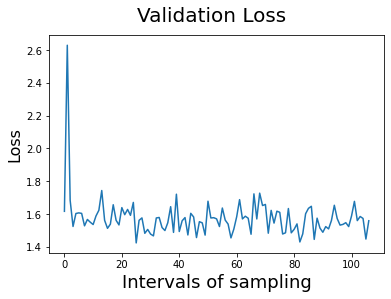

In [50]:
import matplotlib.pyplot as plt


from smdebug.trials import create_trial
from smdebug import modes
import numpy as np
import matplotlib.pyplot as plt


# Get the tensors from S3
s3_output_path = estimator.latest_job_debugger_artifacts_path()

# Create a Trial https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Trial
trial = create_trial(s3_output_path)

# Get all the tensor names
trial.tensor_names()

# Get the values of the tensor `val_acc`for mode GLOBAL (validation accuracy)
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# Convert it to numpy array
values_eval = np.array(list(values.items()))

fig = plt.figure()
plt.plot(values_eval[:, 1])
fig.suptitle('Validation Loss', fontsize=20)
plt.xlabel('Intervals of sampling', fontsize=18)
plt.ylabel('Loss', fontsize=16)
fig.savefig('temp.jpg')



In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


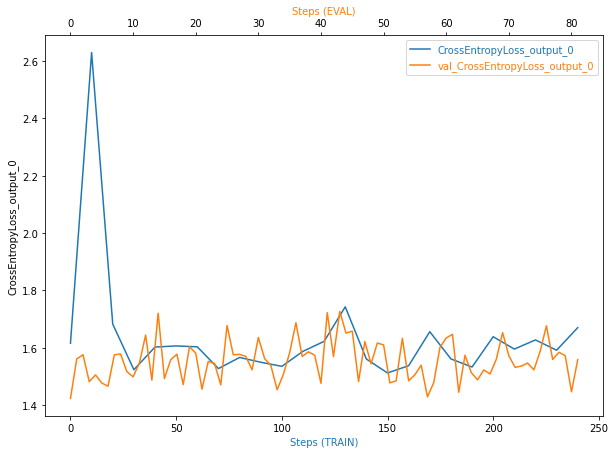

In [52]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [53]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/rule-output
2021-12-15 16:20:32     329710 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-15 16:20:32     171072 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-15 16:20:28        192 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-15 16:20:28        200 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-15 16:20:28        126 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-15 16:20:28        127 Training-job-2021-12-15-15-55-11-903/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-15 16:20:28       

In [54]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [83]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [57]:
estimator.model_data

's3://sagemaker-us-east-1-701620947472/Training-job-2021-12-15-15-55-11-903/output/model.tar.gz'

In [58]:
model_location=estimator.model_data

In [61]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


In [62]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [63]:


predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')



-----!

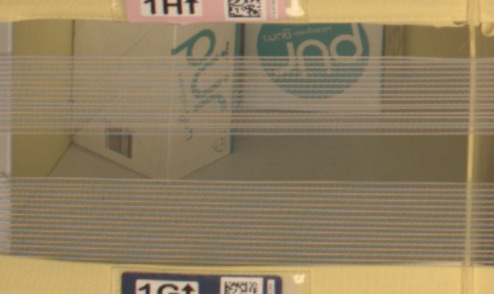

In [65]:

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [79]:
from IPython.display import Image

In [66]:
response=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [67]:


response[0]



[-0.14856533706188202,
 0.1561780571937561,
 0.10614462196826935,
 0.02995668724179268,
 -0.03836285322904587]

In [68]:
np.argmax(response, 1)

array([1])

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

## Cost Analysis

Sagmaker vs EC2 training

### Sagemaker


### Sagemaker cost items are as follows

- GB-Mo of Training Job ML storage
- Studio-Notebook ml.t3.medium hour in US East (N. Virginia)
- Training ml.m5.xlarge hour in US East (N. Virginia)
- SageMaker Studio Notebook Instance ml.g4dn.xlarge per hour


### Overall cost for SageMaker usage - $6.20


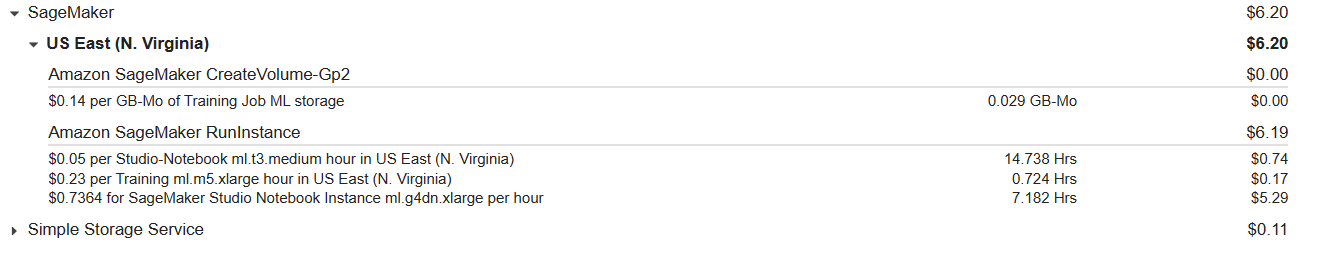

In [81]:
Image("sage.PNG")

### EC2 Model cost Items

- Amazon Elastic Compute Cloud running Linux/UNIX - Demand Linux t2.medium Instance 

- General Purpose SSD (gp2) provisioned storage

### Overall cost for SageMaker usage - $0.11

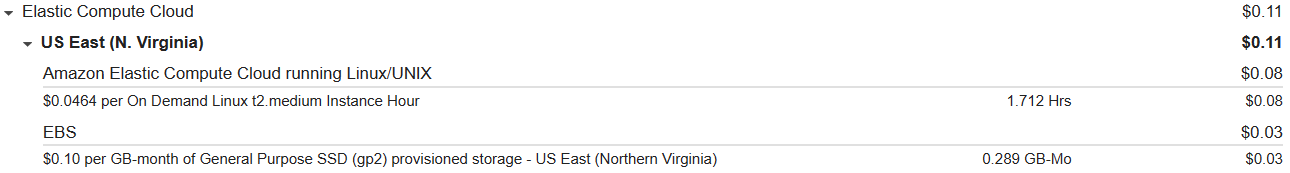

In [82]:
Image("ec.PNG")

### Model training cost in EC2 is less compared to SageMaker. However, higher instance cost and usage will be a factor on considering the workspace 

### Multi-Instance Training

## Number of instance - 2

In [74]:
multi_instance = PyTorch(
    base_job_name="Multi-instance-job",
    sagemaker_session=sagemaker_session,
    entry_point="train.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
multi_instance.fit({"training": "s3://udacitycapstone9/"}, wait=True)

2021-12-15 16:55:44 Starting - Starting the training job...
2021-12-15 16:55:53 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-15 16:57:03 Starting - Preparing the instances for training.........
2021-12-15 16:58:42 Downloading - Downloading input data............
2021-12-15 17:00:44 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-15 17:00:50,000 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-15 17:00:50,004 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-12-15 17:00:50,016 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappr